In [34]:
import os
import sys
import glob
import json
import copy
import tqdm
import soxr
import numpy as np
import pandas as pd
import soundfile as sf

import IPython.display as ipd
import matplotlib.pyplot as plt

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures
import util_stimuli
import util_misc

sys.path.append('/om2/user/msaddler/spatial_audio_pipeline/generate_scenes')
import dataset_multitask

def parse_demographic_survey(raw_data):
    age = None
    gender = None
    hearing_loss = None
    for d in raw_data:
        if 'survey' in d.get('trial_type', ''):
            if age is None:
                age = d.get('response', {}).get('age', None)
            if gender is None:
                gender = d.get('response', {}).get('gender', None)
            if hearing_loss is None:
                hearing_loss = d.get('response', {}).get('hearing_loss', None)
                if isinstance(hearing_loss, str):
                    hearing_loss = True if 'yes' in hearing_loss.lower() else False
    return {'age': age, 'gender': gender, 'hearing_loss': hearing_loss}


In [ ]:
# dir_dst = '/mindhive/mcdermott/www/msaddler/msjspsych/experiment_word_recognition/stim/human_experiment_v00/'
# dir_src = '/om2/user/msaddler/spatial_audio_pipeline/assets/human_experiment_v00/'
# dir_foreground = os.path.join(dir_src, 'foreground_swc')
# list_dir_background = [
#     os.path.join(dir_src, 'background_ieeeaaspcasa'),
#     os.path.join(dir_src, 'background_cv08talkerbabble'),
#     os.path.join(dir_src, 'background_musdb18hq'),
#     os.path.join(dir_src, 'background_issnstationary'),
#     os.path.join(dir_src, 'background_issnfestenplomp'),
# ]
# list_snr = [-9, -6, -3, 0, 3]

# condition = 0
# list_dict_condition = [{
#     'condition': 0,
#     'dir_foreground': dir_foreground,
#     'dir_background': None,
#     'snr': np.inf,
# }]
# for dir_background in list_dir_background:
#     for snr in list_snr:
#         condition += 1
#         list_dict_condition.append({
#             'condition': condition,
#             'dir_foreground': dir_foreground,
#             'dir_background': dir_background,
#             'snr': snr,
#         })

# sr = 20000
# dbspl = 80
# dur = 2.0
# CONFIG = {}
# list_foreground_fn = sorted(glob.glob(os.path.join(dir_foreground, '*.wav')))
# for dict_condition in tqdm.tqdm(list_dict_condition):
#     dir_background = dict_condition['dir_background']
#     snr = dict_condition['snr']
#     dir_dst_condition = os.path.join(dir_dst, 'condition{:02.0f}'.format(dict_condition['condition']))
#     if not os.path.exists(dir_dst_condition):
#         os.mkdir(dir_dst_condition)
#     for itr_fn, foreground_fn in enumerate(list_foreground_fn):
#         y_foreground, sr_foreground = sf.read(foreground_fn, dtype='float32')
#         y_foreground = soxr.resample(y_foreground, sr_foreground, sr)
#         y_foreground = util_stimuli.pad_or_trim_to_len(y_foreground, int(dur * sr))
#         if dir_background is not None:
#             background_fn = os.path.join(dir_background, '{:03.0f}.wav'.format(itr_fn))
#             y_background, sr_background = sf.read(background_fn, dtype='float32')
#             y_background = soxr.resample(y_background, sr_background, sr)
#             y_background = util_stimuli.pad_or_trim_to_len(y_background, int(dur * sr))
#         else:
#             background_fn = None
#             y_background = np.zeros_like(y_foreground)
#         y = util_stimuli.combine_signal_and_noise(y_foreground, y_background, snr)
#         y = util_stimuli.set_dBSPL(y, dbspl)
#         fn_dst = os.path.join(dir_dst_condition, '{:03.0f}.wav'.format(itr_fn))
#         sf.write(fn_dst, y, sr, subtype='FLOAT')
#         CONFIG[fn_dst.replace(dir_dst, '')] = {
#             'snr': snr,
#             'correct_response': foreground_fn[foreground_fn.rfind('_')+1:foreground_fn.rfind('.')],
#             'background_condition': os.path.basename(dir_background) if dir_background is not None else None,
#             'background_fn': background_fn,
#             'foreground_fn': foreground_fn,
#             'foreground_index': itr_fn,
#         }

# with open(os.path.join(dir_dst, 'config.json'), 'w') as f:
#     json.dump(CONFIG, f, indent=4, sort_keys=True)


In [28]:
# dir_dst = '/mindhive/mcdermott/www/msaddler/msjspsych/experiment_word_recognition/stim/human_experiment_v00_STRAIGHT/'
# dir_src = '/om2/user/msaddler/spatial_audio_pipeline/assets/human_experiment_v00/'

# list_dir_foreground = [
#     os.path.join(dir_src, 'foreground_swc'),
#     os.path.join(dir_src, 'STRAIGHT/foreground_swc_inharmonic'),
#     os.path.join(dir_src, 'STRAIGHT/foreground_swc_whispered'),
#     os.path.join(dir_src, 'STRAIGHT/foreground_swc_shifted_f0_N12semitones'),
#     os.path.join(dir_src, 'STRAIGHT/foreground_swc_shifted_f0_N06semitones'),
#     os.path.join(dir_src, 'STRAIGHT/foreground_swc_shifted_f0_N03semitones'),
#     os.path.join(dir_src, 'STRAIGHT/foreground_swc_shifted_f0_P00semitones'),
#     os.path.join(dir_src, 'STRAIGHT/foreground_swc_shifted_f0_P03semitones'),
#     os.path.join(dir_src, 'STRAIGHT/foreground_swc_shifted_f0_P06semitones'),
#     os.path.join(dir_src, 'STRAIGHT/foreground_swc_shifted_f0_P12semitones'),
# ]
# list_dir_background = [None] * len(list_dir_foreground)
# list_snr = [np.inf] * len(list_dir_foreground)

# FOREGROUND_INDEX_TO_EXCLUDE = [1, 51, 59, 111, 113, 124, 136, 146, 155, 176, 188, 207, 212, 237, 282, 291, 313, 321, 353, 368, 375]

# condition = 0
# list_dict_condition = []
# for condition, (dir_foreground, dir_background, snr) in enumerate(zip(list_dir_foreground, list_dir_background, list_snr)):
#     list_dict_condition.append({
#         'condition': condition,
#         'dir_foreground': dir_foreground,
#         'dir_background': dir_background,
#         'snr': snr,
#     })

# list_dict_condition
# sr = 20000
# dbspl = 80
# dur = 2.0
# CONFIG = {}


# for dict_condition in tqdm.tqdm(list_dict_condition):
#     dir_foreground = dict_condition['dir_foreground']
#     dir_background = dict_condition['dir_background']
#     snr = dict_condition['snr']
#     dir_dst_condition = os.path.join(dir_dst, 'condition{:02.0f}'.format(dict_condition['condition']))
#     if not os.path.exists(dir_dst_condition):
#         os.mkdir(dir_dst_condition)
#     list_foreground_fn = sorted(glob.glob(os.path.join(dir_foreground, '*.wav')))
#     for itr_fn, foreground_fn in enumerate(list_foreground_fn):
#         if itr_fn in FOREGROUND_INDEX_TO_EXCLUDE:
#             print(f'Excluding foreground_index={itr_fn} ({foreground_fn})')
#         else:
#             y_foreground, sr_foreground = sf.read(foreground_fn, dtype='float32')
#             y_foreground = soxr.resample(y_foreground, sr_foreground, sr)
#             y_foreground = util_stimuli.pad_or_trim_to_len(y_foreground, int(dur * sr))
#             if dir_background is not None:
#                 background_fn = os.path.join(dir_background, '{:03.0f}.wav'.format(itr_fn))
#                 y_background, sr_background = sf.read(background_fn, dtype='float32')
#                 y_background = soxr.resample(y_background, sr_background, sr)
#                 y_background = util_stimuli.pad_or_trim_to_len(y_background, int(dur * sr))
#             else:
#                 background_fn = None
#                 y_background = np.zeros_like(y_foreground)
#             y = util_stimuli.combine_signal_and_noise(y_foreground, y_background, snr)
#             y = util_stimuli.set_dBSPL(y, dbspl)
#             fn_dst = os.path.join(dir_dst_condition, '{:03.0f}.wav'.format(itr_fn))
#             sf.write(fn_dst, y, sr, subtype='FLOAT')
#             CONFIG[fn_dst.replace(dir_dst, '')] = {
#                 'snr': snr,
#                 'correct_response': foreground_fn[foreground_fn.rfind('_')+1:foreground_fn.rfind('.')],
#                 'foreground_condition': dir_foreground.replace(dir_src, '') if dir_foreground is not None else None,
#                 'background_condition': os.path.basename(dir_background) if dir_background is not None else None,
#                 'background_fn': background_fn,
#                 'foreground_fn': foreground_fn,
#                 'foreground_index': itr_fn,
#             }

# with open(os.path.join(dir_dst, 'config.json'), 'w') as f:
#     json.dump(CONFIG, f, indent=4, sort_keys=True)


In [ ]:
# dir_dst = '/mindhive/mcdermott/www/msaddler/msjspsych/experiment_word_recognition/stim/human_experiment_v00/'
# with open(os.path.join(dir_dst, 'config.json'), 'r') as f:
#     CONFIG = json.load(f)

# map_foreground_index_to_correct_response = {}
# for k in CONFIG.keys():
#     map_foreground_index_to_correct_response[CONFIG[k]['foreground_index']] = CONFIG[k]['correct_response']
# # for k in sorted(map_foreground_index_to_correct_response.keys()):
# #     print(f'"{map_foreground_index_to_correct_response[k]}",')


In [ ]:
# fn_wsn = '/om2/user/msaddler/spatial_audio_pipeline/assets/wsn/manifest_JSIN_behavioral_unique_speech.pdpkl'
# fn_v04 = '/om2/user/msaddler/spatial_audio_pipeline/assets/dataset_multitask/v04/manifest_foreground_speech_valid.pdpkl'
# df_wsn = pd.read_pickle(fn_wsn)
# df_v04 = pd.read_pickle(fn_v04)
# df_v04 = df_v04[df_v04.word_int > 0]
# list_word_wsn = sorted(df_wsn.word.unique())
# list_word_v04 = sorted(df_v04.word.unique())
# list_word = [w.replace("'", "") for w in sorted(list_word_wsn)]
# for _, w in map_foreground_index_to_correct_response.items():
#     assert w in list_word
# # for w in list_word:
# #     print(f'"{w}",')

# # Generate catch trials from stimuli excluded from experiment due to low sampling rate
# df = df_wsn[(df_wsn.word.isin(list_word_wsn)) & (df_wsn.word.isin(list_word_v04)) & (df_wsn.sr < 32e3)]
# df = df.drop(columns=['path', 'corpus_int', 'label_talker_int', 'label_word_int', 'talker_int', 'word_int'])
# df.word = df.word.map(lambda _: _.lower().replace("'", ""))
# df = df[df.word.isin(list_word)]
# df = df.sort_values(by='word').reset_index(drop=True)
# ramp_dur = 0.020
# df['clip_start_in_s'] = df['clip_start_in_s'] - ramp_dur
# df['clip_end_in_s'] = df['clip_end_in_s'] + ramp_dur

# dir_dst = '/mindhive/mcdermott/www/msaddler/msjspsych/experiment_word_recognition/stim/human_experiment_v00/catch'
# if not os.path.exists(dir_dst):
#     os.mkdir(dir_dst)

# sr = 20000
# dbspl = 80
# dur = 2.0
# for index in range(len(df)):
#     dfi = df.iloc[index]
#     dur_word = dfi.clip_end_in_s - dfi.clip_start_in_s
#     y = dataset_multitask.get_excerpt(
#         dfi,
#         dur=dur_word,
#         sr=sr,
#         pad_with_context=False,
#         jitter_fraction=0).astype(np.float32)
#     y = y * util_stimuli.get_hanning_window(
#         sr,
#         dur_word,
#         ramp_dur=ramp_dur,
#         flat_onset=ramp_dur,
#         flat_offset=dur_word-ramp_dur)
#     y = util_stimuli.set_dBSPL(y, dbspl)
#     y = util_stimuli.pad_or_trim_to_len(y, int(dur * sr))
    
#     fn_dst = os.path.join(dir_dst, '{:03.0f}.wav'.format(index))
#     sf.write(fn_dst, y, sr, subtype='FLOAT')
    
#     assert dfi.word in list_word
#     print(f'"{dfi.word}",')


In [35]:
regex_fn_data = 'data/human_experiment_v00/subj_*.json'
fn_config = 'stim/human_experiment_v00/config.json'
# regex_fn_data = 'data/human_experiment_v00_STRAIGHT/subj_*.json'
# fn_config = 'stim/human_experiment_v00_STRAIGHT/config.json'

min_trials = 100
catch_fraction = 0.75
verbose = False

with open(fn_config, 'r') as f:
    CONFIG = json.load(f)

list_fn_data = sorted(glob.glob(regex_fn_data))
list_df = []
for fn_data in list_fn_data:
    error_tag = False
    try:
        with open(fn_data, 'r') as f:
            raw_data = json.load(f)
    except:
        error_tag = True
        with open(fn_data, 'r') as f:
            raw_data = f.read()
        raw_data = raw_data[:raw_data.rfind(',')]
        if raw_data.endswith('}'):
            raw_data = raw_data + ']'
        else:
            raw_data = raw_data + '}]'
        raw_data = json.loads(raw_data)
    demographic_data = parse_demographic_survey(raw_data)
    data = [d for d in raw_data if d.get('trial_type', '') == 'dictionary-text']
    if verbose:
        print(fn_data, len(data), "<-- JSON ERROR" if error_tag else '')
    df = pd.DataFrame(data)
    for k, v in demographic_data.items():
        df[k] = v
    list_df.append(df)


In [39]:
assert ('human_experiment_v00/' in fn_config) and ('human_experiment_v00/' in regex_fn_data)

df_results = pd.concat(list_df).sort_index(axis=1)

df_results['snr'] = df_results['stimulus'].map(
    lambda _: CONFIG.get(_.replace('stim/human_experiment_v00/', ''), {}).get('snr', None))
df_results['background_condition'] = df_results['stimulus'].map(
    lambda _: CONFIG.get(_.replace('stim/human_experiment_v00/', ''), {}).get('background_condition', None))
df_results['background_condition'] = df_results['background_condition'].fillna('background_SILENCE')
df_results['word'] = df_results['stimulus'].map(
    lambda _: CONFIG.get(_.replace('stim/human_experiment_v00/', ''), {}).get('correct_response', None))

df_results = df_results.groupby('id_subject').filter(
    lambda g: np.logical_and(g[g.catch_trial == 1].correct.mean() >= catch_fraction, len(g) >= min_trials))
df_results = util_misc.flatten_columns(df_results[
    (df_results['catch_trial'] == 0) &
    (df_results['trial_num'] >= 0) &
    (df_results['trial_num'] <= 400)
].groupby(['id_subject', 'background_condition', 'snr']).agg({
    'correct': ['mean', 'sum', 'count'],
    'age': 'first',
    'gender': 'first',
    'hearing_loss': 'first',
}).reset_index()).rename(columns={
    'id_subject': 'participant_id',
    'age/first': 'participant_age',
    'gender/first': 'participant_gender',
    'hearing_loss/first': 'participant_hearing_loss',
}).sort_index(axis=1)

df_results_to_plot = util_misc.flatten_columns(df_results[
    df_results['participant_hearing_loss'] == False
].groupby(['background_condition', 'snr']).agg({
    'correct/mean': ['mean', 'count', 'sem'],
}).reset_index()).rename(columns={
    'correct/mean/mean': 'mean',
    'correct/mean/count': 'n',
    'correct/mean/sem': 'sem',
})

fn_results = 'data/human_experiment_v00/combined_results.csv'
df_results.sort_index(axis=1).to_csv(fn_results, index=False)
print(f'Wrote: {fn_results}')

fn_results_to_plot = 'data/human_experiment_v00/combined_results_to_plot.csv'
df_results_to_plot.sort_index(axis=1).to_csv(fn_results_to_plot, index=False)
print(f'Wrote: {fn_results_to_plot}')

df_results_to_plot


Wrote: data/human_experiment_v00/combined_results.csv
Wrote: data/human_experiment_v00/combined_results_to_plot.csv


,background_condition,snr,mean,n,sem
0,background_SILENCE,inf,0.788693,82,0.016813
1,background_cv08talkerbabble,-9.0,0.023403,82,0.004757
2,background_cv08talkerbabble,-6.0,0.054161,82,0.007746
3,background_cv08talkerbabble,-3.0,0.168683,82,0.012997
4,background_cv08talkerbabble,0.0,0.376188,82,0.015179
5,background_cv08talkerbabble,3.0,0.561132,82,0.018973
6,background_ieeeaaspcasa,-9.0,0.155742,82,0.011367
7,background_ieeeaaspcasa,-6.0,0.260333,82,0.015056
8,background_ieeeaaspcasa,-3.0,0.418723,82,0.016392
9,background_ieeeaaspcasa,0.0,0.573885,82,0.018567


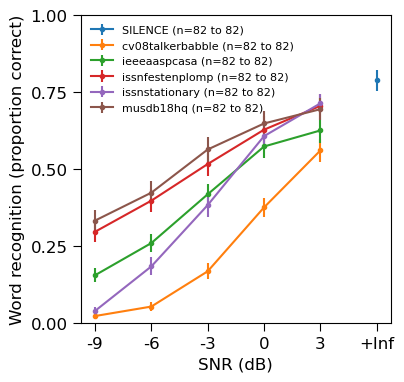

In [41]:
fig, ax = plt.subplots(figsize=(4, 4))
for background_condition in sorted(df_results_to_plot.background_condition.unique()):
    IDX = df_results_to_plot.background_condition == background_condition
    x = df_results_to_plot[IDX]['snr'].values
    y = df_results_to_plot[IDX]['mean'].values
    yerr = 2 * df_results_to_plot[IDX]['sem'].values
    x[x > 6] = 6
    n = df_results_to_plot[IDX]['n']
    label = f"{background_condition.replace('background_', '')} (n={n.min()} to {n.max()})"
    ax.errorbar(x, y, yerr=yerr, label=label, marker='.')
ax.legend(frameon=False, fontsize=8, loc='upper left')
ax = util_figures.format_axes(
    ax,
    xticks=[-9, -6, -3, 0, 3, 6],
    xticklabels=[-9, -6, -3, 0, 3, '+Inf'],
    yticks=[0, 0.25, 0.5, 0.75, 1],
    ylimits=[0, 1],
    str_xlabel='SNR (dB)',
    str_ylabel='Word recognition (proportion correct)')
plt.show()


In [32]:
assert ('human_experiment_v00_STRAIGHT' in fn_config) and ('human_experiment_v00_STRAIGHT' in regex_fn_data)

df_results = pd.concat(list_df).sort_index(axis=1)

df_results['condition'] = df_results['stimulus'].map(
    lambda _: CONFIG.get(_.replace('stim/human_experiment_v00_STRAIGHT/', ''), {}).get(
        'foreground_condition', '').replace(
        'STRAIGHT/foreground_swc_', '').replace(
        'shifted_f0_N', 'harmonic_shift-').replace(
        'shifted_f0_P', 'harmonic_shift+').replace(
        'semitones', '').replace(
        'foreground_swc', 'natural'))
df_results = df_results.groupby('id_subject').filter(
    lambda g: np.logical_and(g[g.catch_trial == 1].correct.mean() >= catch_fraction, len(g) >= min_trials))
df_results = util_misc.flatten_columns(df_results[
    (df_results['catch_trial'] == 0) &
    (df_results['trial_num'] >= 0) &
    (df_results['trial_num'] <= 400)
].groupby(['id_subject', 'condition']).agg({
    'correct': ['mean', 'sum', 'count'],
    'age': 'first',
    'gender': 'first',
    'hearing_loss': 'first',
}).reset_index()).rename(columns={
    'id_subject': 'participant_id',
    'age/first': 'participant_age',
    'gender/first': 'participant_gender',
    'hearing_loss/first': 'participant_hearing_loss',
}).sort_index(axis=1)

df_results_to_plot = util_misc.flatten_columns(df_results[
    df_results['participant_hearing_loss'] == False
].groupby('condition').agg({
    'correct/mean': ['mean', 'count', 'sem'],
}).reset_index()).rename(columns={
    'correct/mean/mean': 'mean',
    'correct/mean/count': 'n',
    'correct/mean/sem': 'sem',
})

fn_results = 'data/human_experiment_v00_STRAIGHT/combined_results.csv'
df_results.sort_index(axis=1).to_csv(fn_results, index=False)
print(f'Wrote: {fn_results}')

fn_results_to_plot = 'data/human_experiment_v00_STRAIGHT/combined_results_to_plot.csv'
df_results_to_plot.sort_index(axis=1).to_csv(fn_results_to_plot, index=False)
print(f'Wrote: {fn_results_to_plot}')

df_results_to_plot


Wrote: data/human_experiment_v00_STRAIGHT/combined_results.csv
Wrote: data/human_experiment_v00_STRAIGHT/combined_results_to_plot.csv


,condition,mean,n,sem
0,harmonic_shift+00,0.802540,31,0.015425
1,harmonic_shift+03,0.784896,31,0.014585
2,harmonic_shift+06,0.773780,31,0.015753
3,harmonic_shift+12,0.774515,31,0.015176
4,harmonic_shift-03,0.773764,31,0.015336
5,harmonic_shift-06,0.765928,31,0.019426
6,harmonic_shift-12,0.771725,31,0.018162
7,inharmonic,0.796321,31,0.013455
8,natural,0.778844,31,0.023128
9,whispered,0.744761,31,0.015560


[31 31 31 31 31 31 31 31 31 31]


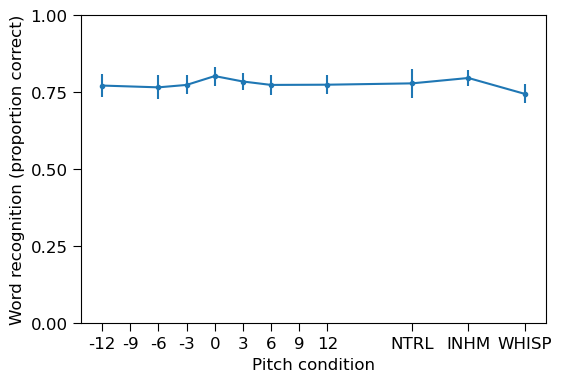

In [26]:
map_condition_to_x = {
    'harmonic_shift-12': -12,
    'harmonic_shift-06': -6,
    'harmonic_shift-03': -3,
    'harmonic_shift+00': 0,
    'harmonic_shift+03': 3,
    'harmonic_shift+06': 6,
    'harmonic_shift+12': 12,
    'natural': 21,
    'inharmonic': 27,
    'whispered': 33,
}
x = df_results_to_plot['condition'].map(map_condition_to_x).values
IDX = np.argsort(x)
x = x[IDX]
y = df_results_to_plot['mean'].values[IDX]
yerr = 2 * df_results_to_plot['sem'].values[IDX]
n = df_results_to_plot['n'].values[IDX]
print(n)

fig, ax = plt.subplots(figsize=(6, 4))
ax.errorbar(x, y, yerr=yerr, marker='.')
ax = util_figures.format_axes(
    ax,
    xticks=[-12, -9, -6, -3, 0, 3, 6, 9, 12, 21, 27, 33],
    xticklabels=[-12, -9, -6, -3, 0, 3, 6, 9, 12, 'NTRL', 'INHM', "WHISP"],
    yticks=[0, 0.25, 0.5, 0.75, 1],
    ylimits=[0, 1],
    str_xlabel='Pitch condition',
    str_ylabel='Word recognition (proportion correct)')
plt.show()
